In [3]:
# spreadingmind

import requests
import json
from lxml import html
from ncbiumls.authorization import authorization
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline


class UMLS(authorization):
    def __init__(self, api_key='e9990d5d-ff93-40f1-9f60-29ce7cf2950c'):
        super().__init__(str(api_key))

    def askTerm(self, term, inputType='atom', includeObsolete='false', includeSuppressible='false',
                returnIdType='concept', searchType='words', pageNumber=1, pageSize=25):

#   TODO: Add option like dump, if enabled - save data, current page, page size
#   TODO: Write some messages on succesfull access, like pageNumber etc.

        """
        Description: retrives all records associted with the term, returns list of dicts,
                     each dict have keywords name,uri,ui,rootSource.


        :param term:                A human readable term, such as 'gestatational diabetes', or a code from a source
                                    vocabulary, such as 11687002 from SNOMEDCT_US.

        :param inputType:           Specifies the data type you are using as your search parameter.
                                    Valid values:  'atom', 'code','sourceConcept','sourceDescriptor','sourceUi','tty'
                                    Default value: 'atom'
                                    Usage Note:     Use 'sourceUi' if you aren't sure if the identifier you're providing
                                                    is a code, source concept, or source descriptor. Using 'tty' is for
                                                    advanced use cases and will extract codes from a specified
                                                    vocabulary according to term type.

        :param includeObsolete:     Return content that is a result of matches on obsolete terms.
                                    Valid values:   true or false
                                    Default value: 'false'

        :param includeSuppressible: Return content that is a result of matches on suppressible terms.
                                    Valid values:   true or false
                                    Default value: 'false'

        :param returnIdType:        Specifies the type of identifier you wish to retrieve.
                                    Valid values:   true or false
                                    Default value: 'false'
                                    Usage Note:     Use 'code','sourceConcept', 'sourceDescriptor', or 'sourceUi' if you
                                                    prefer source-asserted identifiers rather than CUIs in your search
                                                    results.

        :param searchType:          Type of search you wish to use.
                                    Valid values:  'exact','words','leftTruncation', 'rightTruncation','approximate',
                                                   'normalizedString'
                                    Default value: 'words'
                                    Usage Note:     Use 'exact' when using inputType = 'code', 'sourceConcept',
                                                   'sourceDescriptor', or 'sourceUi'.

        :param pageNumber:          Whole number that specifies which page of results to fetch
                                    Valid values:   1,2,3, etc
                                    Default value:  1

        :param pageSize:            Whole number that specifies the number of results to include per page.
                                    Valid values:   1,2,3, etc
                                    Default value:  25

        :return:
        """
        # main url and parameters
        url = 'https://uts-ws.nlm.nih.gov/rest/search/current'
        params = {'ticket': '',
                  'string': str(term),
                  'inputType': inputType,
                  'includeObsolete': includeObsolete,
                  'includeSuppressible': includeSuppressible,
                  'returnIdType': returnIdType,
                  'searchType': searchType,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}

        #varible to store received data
        data = []

        #in case specific page is not provided - grab all results starting from page 1
        if pageNumber == 1:

            #function is guaranteed to return results so ask cycle will roll infinitely
            while True:

                #get a service ticket
                params['ticket'] = self.getST()

                #access page
                get = requests.get(url=url, params=params)
                try:

                    #if all the results obtained return gathered data
                    if get.json()['result'] == {'results': [{'ui': 'NONE', 'name': 'NO RESULTS'}],
                                                  'classType': 'searchResults'}:
                        return data

                    #else grab some more data
                    else:
                        for item in get.json()['result']['results']:
                            data.append(item)
                        params['pageNumber'] += 1

                #if server returned error - try to print that error, wait and retry request
                except Exception as exp:
                    response = html.fromstring(data.text)
                    print(response.xpath('.//p/b[contains(text(),"description")]/following::u')[0].text,
                          ', current page number = ' + str(pageNumber),
                          ', current page size = ' + str(pageSize))

                #to not overlode server pause a bit
                sleep(0.5)

        #else access specific page
        else:
            params['ticket'] = self.getST()
            get = requests.get(url=url, params=params)
            try:
                return get.json()['result']['results']
            except Exception as exp:
                response = html.fromstring(data.text)
                print(response.xpath('.//p/b[contains(text(),"description")]/following::u')[0].text,
                      ', current page number = ' + str(pageNumber),
                      ', current page size = ' + str(pageSize))



class CUI(authorization):
    def __init__(self, api_key='e9990d5d-ff93-40f1-9f60-29ce7cf2950c'):
        super().__init__(api_key=api_key)

    def CUIGeneral(self, cui):
        """
        :param cui: The Concept Unique Identifier for a Metathesaurus concept
        :return: Returns dictionary processed from JSON, example:
                {
                    "pageSize": 25,
                    "pageNumber": 1,
                    "pageCount": 1,
                    "result": {
                        "classType": "Concept",
                        "ui": "C0009044",
                        "suppressible": false,
                        "dateAdded": "09-30-1990",
                        "majorRevisionDate": "08-18-2015",
                        "status": "R",
                        "semanticTypes": [
                            {
                                "name": "Injury or Poisoning",
                                "uri": "https://uts-ws.nlm.nih.gov/rest/semantic-network/2015AB/TUI/T037"
                            }
                        ],
                        "atomCount": 63,
                        "attributeCount": 0,
                        "cvMemberCount": 0,
                        "atoms": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/atoms",
                        "definitions": "NONE",
                        "relations": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/relations",
                        "defaultPreferredAtom": "https://uts-ws.nlm.nih.gov/rest/content/
                                                        2015AB/CUI/C0009044/atoms/preferred",
                        "relationCount": 5,
                        "name": "Closed fracture carpal bone"
                    }
                }
        """
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui)
        params = {'ticket': stTicket}
        data = requests.get(url=url, params=params)
        try:
            return data.json()

        except Exception as exp:
            response = html.fromstring(data.text)
            return response.xpath('.//p/b[text()="message"]/u')

    def CUISemanticTypes(self, cui):
        """
        :param cui: The Concept Unique Identifier for a Metathesaurus concept
        :return: Returns dictionary processed from JSON, example:
                {
                    "pageSize": 25,
                    "pageNumber": 1,
                    "pageCount": 1,
                    "result": {
                        "classType": "Concept",
                        "ui": "C0009044",
                        "suppressible": false,
                        "dateAdded": "09-30-1990",
                        "majorRevisionDate": "08-18-2015",
                        "status": "R",
                        "semanticTypes": [
                            {
                                "name": "Injury or Poisoning",
                                "uri": "https://uts-ws.nlm.nih.gov/rest/semantic-network/2015AB/TUI/T037"
                            }
                        ],
                        "atomCount": 63,
                        "attributeCount": 0,
                        "cvMemberCount": 0,
                        "atoms": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/atoms",
                        "definitions": "NONE",
                        "relations": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/relations",
                        "defaultPreferredAtom": "https://uts-ws.nlm.nih.gov/rest/content/
                                                        2015AB/CUI/C0009044/atoms/preferred",
                        "relationCount": 5,
                        "name": "Closed fracture carpal bone"
                    }
                }
        """
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui)
        params = {'ticket': stTicket}
        data = requests.get(url=url, params=params)
        try:
            return data.json()['result']['semanticTypes']

        except Exception as exp:
            response = html.fromstring(data.text)
            return response.xpath('.//p/b[text()="message"]/u')

    def CUIAtoms(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/atoms'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

    def CUIDefenitions(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/definitions'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

    def CUIRelations(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/relations'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

In [117]:
def get_sorted(p_dict):
    return sorted(p_dict.items(), key=lambda x: x[1], reverse=True)

In [111]:
import os

data = {}

for i in os.listdir('json/'):
    print(i)
    year = int(i.split('.')[0])
    with open('json/{}'.format(i)) as data_file:
        data[year] = json.load(data_file)
        for i in ['chemicals', 'mesh_titles']:
            for key, val in data[year][i].items():
                data[year][i][key] = val/data[year]['count_articles']

1990.json
1991.json
1992.json
1993.json
1994.json
1995.json
1996.json
1997.json
1998.json
1999.json
2000.json
2001.json
2002.json
2003.json
2004.json
2005.json
2006.json
2007.json
2008.json
2009.json
2010.json
2011.json
2012.json
2013.json
2014.json
2015.json
2016.json
2017.json


In [113]:
with open('top100_mt.txt', 'w') as f:
    f.write('\n'.join(list(map(lambda x: x[0], get_sorted(data[2009]['mesh_titles'])[:100]))))

In [114]:
with open('top100_chem.txt', 'w') as f:
    f.write('\n'.join(list(map(lambda x: x[0], get_sorted(data[2009]['chemicals'])[:100]))))

In [123]:
top100_mt = list(map(lambda x: x[0], get_sorted(data[2009]['mesh_titles'])[:100]))
top100_chem = list(map(lambda x: x[0], get_sorted(data[2009]['chemicals'])[:100]))

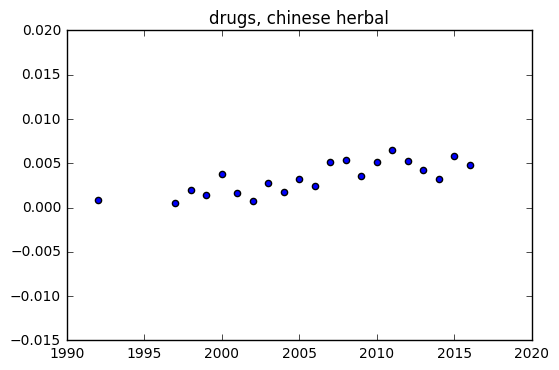

In [267]:
to_draw = []
inxs = []

for i in range(1990, 2018):
    term = 'drugs, chinese herbal'
    if i in data and term in data[i]['chemicals']:
        tmp = data[i]['chemicals'][term]
        to_draw.append(tmp)
        inxs.append(i)
        
plt.figure()
plt.title(term)
plt.scatter(inxs, to_draw)

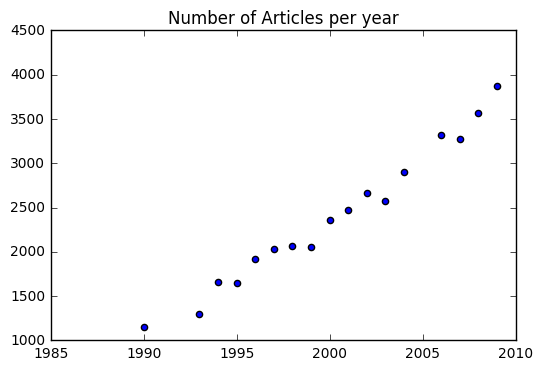

In [95]:
to_draw = []
inxs = []

for i in range(1990, 2018):
    if i in data:
        tmp = data[i]['count_articles']
        to_draw.append(tmp)
        inxs.append(i)
#         print(i, tmp)
        
plt.figure()
plt.scatter(inxs, to_draw)
plt.title('Number of Articles per year')

In [167]:
data_umls = UMLS()

print(data_umls.getST())
print(data_umls.tgt.split('/')[-1])

ST-2655560-W4WuSkdOyYt5poGgubeF-cas
TGT-1186547-r3RDJp0OyXfF2bai7Bqp9HcTb7PdM0iClJs4DIkxBwGKMLdGLw-cas


In [164]:
# top100_chem
# top100_mt

In [165]:
top100_chem[12:15]

['amyloid beta-peptides',
 'peptide fragments',
 'amyloid beta-protein precursor']

In [170]:
def echo(p_dict, p_str):
    print('--> {}'.format(p_str))
    print(p_dict)
    print()

m_dict_ui_by_term = {} # term : ui
m_dict_term_by_ui = {} # ui : term

m_dict_sem_types_by_ui = {} # ui : [name1, name2, ...]
m_dict_uis_by_st = {} # sem_type : [ui1, ui2, ...]

m_dict_sem_types_by_term = {}
m_dict_term_by_st = {}

for n, m_term in enumerate(top100_chem[12:]):
# for m_term in top100_chem[61:63]:
    
    echo(m_term, 'TERM')
    print(n)
    res = data_umls.askTerm(m_term, pageSize=100000, searchType='exact')

    if len(res) == 0:
        print('<empty>')
        continue
    
    for i in res:
        ui = i['ui']
        name = i['name']
        
        if ui not in m_dict_ui_by_name:
            m_dict_ui_by_name[ui] = []
        m_dict_ui_by_name[ui].append(name)

        if m_term not in m_dict_ui_by_term:
            m_dict_ui_by_term[m_term] = []
        m_dict_ui_by_term[m_term].append(ui)

        if ui not in m_dict_term_by_ui:
            m_dict_term_by_ui[ui] = []
        m_dict_term_by_ui[ui].append(m_term)

    m_cui = CUI()

    print('---')
    print(m_dict_ui_by_term)
    print(m_term)
    print('+++')
    for ui in m_dict_ui_by_term[m_term]:
        query_res = m_cui.CUIGeneral(ui)
        
        term = m_dict_term_by_ui[ui][0]
        print('>>>')
        print(m_dict_term_by_ui)
        print(ui)
        print('<<<')
        
        if ui == 'C0611285':
            term = 'app protein, human'
        else:
            assert(len(m_dict_term_by_ui[ui]) == 1)
        
        for sem_type in query_res['result']['semanticTypes']:
            st_name = sem_type['name']
            
            if term not in m_dict_sem_types_by_term:
                m_dict_sem_types_by_term[term] = []
            if st_name not in m_dict_sem_types_by_term[term]:
                m_dict_sem_types_by_term[term].append(st_name)
            
            if st_name not in m_dict_term_by_st:
                m_dict_term_by_st[st_name] = []
            if term not in m_dict_term_by_st[st_name]:
                m_dict_term_by_st[st_name].append(term)
            
#             if st_name not in m_dict_uis_by_st:
#                 m_dict_uis_by_st[st_name] = []
#             m_dict_uis_by_st[st_name].append(ui)
            
#             if ui not in m_dict_sem_types_by_ui:
#                 m_dict_sem_types_by_ui[ui] = []
#             m_dict_sem_types_by_ui[ui].append(st_name)

print()
print('<---FINISH--->')
echo(m_dict_ui_by_term, 'UI by Term')
echo(m_dict_term_by_ui, 'Term by UI')
# echo(m_dict_uis_by_st, 'UI by semanticTypes')
# echo(m_dict_sem_types_by_ui, 'semanticTypes by UI')
echo(m_dict_term_by_st, 'Term by semanticTypes')
echo(m_dict_sem_types_by_term, 'semanticTypes by Term')

--> TERM
amyloid beta-peptides

0
---
{'amyloid beta-peptides': ['C0078939']}
amyloid beta-peptides
+++
>>>
{'C0078939': ['amyloid beta-peptides']}
C0078939
<<<
--> TERM
peptide fragments

1
---
{'peptide fragments': ['C0030935'], 'amyloid beta-peptides': ['C0078939']}
peptide fragments
+++
>>>
{'C0030935': ['peptide fragments'], 'C0078939': ['amyloid beta-peptides']}
C0030935
<<<
--> TERM
amyloid beta-protein precursor

2
---
{'peptide fragments': ['C0030935'], 'amyloid beta-peptides': ['C0078939'], 'amyloid beta-protein precursor': ['C0085151']}
amyloid beta-protein precursor
+++
>>>
{'C0085151': ['amyloid beta-protein precursor'], 'C0030935': ['peptide fragments'], 'C0078939': ['amyloid beta-peptides']}
C0085151
<<<
--> TERM
tau proteins

3
---
{'peptide fragments': ['C0030935'], 'tau proteins': ['C0085401'], 'amyloid beta-peptides': ['C0078939'], 'amyloid beta-protein precursor': ['C0085151']}
tau proteins
+++
>>>
{'C0085401': ['tau proteins'], 'C0085151': ['amyloid beta-protein pr

In [ ]:
term_by_sem_type
m_dict_sem_types_by_term

In [172]:
import json
with open('CHEM_sem_types_by_term.txt', 'w') as outfile:
    json.dump(m_dict_sem_types_by_term, outfile)

In [261]:
def is_good(term, sem_types):
#     if 'Amino Acid, Peptide, or Protein' in sem_types:
#         return True
#     else:
#         return False
    if 'proteins' in term:
        return True
    else:
        return False
    
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    
    def is_contain(list1, list2):
        for x in list1:
            if x in list2:
                return True
        return False
    
    good_list = ['Organic Chemical', 'Amino Acid, Peptide, or Protein', 
                 'Pharmacologic Substance', 'Biologically Active Substance', 
                 '-']
    if is_contain(good_list, sem_types):
        return True
    else:
        return False

def is_good_term(term):
    if 'proteins' in term:
        return True
    else:
        return False
    
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    return True
    

to_df = []

for year in range(1990, 2018):
    top100_chem = list(map(lambda x: x[0], get_sorted(data[year]['chemicals'])[:100]))
    for inst in top100_chem[12:]:
        tmp = data[year]['chemicals'][inst]
        to_print = str(year) + ' ' + '{' + inst + '}' + ' ' + '{:3f}'.format(tmp) + ' '
        
        if inst in m_dict_sem_types_by_term:
            to_print += '[' + '; '.join(m_dict_sem_types_by_term[inst]) + ']'
        else:
            to_print += ' - '
            
        if inst in m_dict_sem_types_by_term:
            sem_types = m_dict_sem_types_by_term[inst]
            if is_good(inst, sem_types):
                to_df.append([year, inst, '{:3f}'.format(tmp), sem_types])
        elif is_good_term(inst):
                to_df.append([year, inst, '{:3f}'.format(tmp), '-'])

to_df

[[1990,
  'nerve tissue proteins',
  '0.040870',
  ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']],
 [1990,
  'tau proteins',
  '0.034783',
  ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']],
 [1990, 'microtubule-associated proteins', '0.033913', '-'],
 [1990, 'intermediate filament proteins', '0.008696', '-'],
 [1990,
  'recombinant proteins',
  '0.007826',
  ['Amino Acid, Peptide, or Protein']],
 [1990, 'neurofilament proteins', '0.006957', '-'],
 [1990,
  'membrane proteins',
  '0.006087',
  ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']],
 [1990, 'blood proteins', '0.004348', '-'],
 [1991,
  'tau proteins',
  '0.033175',
  ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']],
 [1991,
  'nerve tissue proteins',
  '0.032385',
  ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']],
 [1991, 'microtubule-associated proteins', '0.023697', '-'],
 [1991, 'neurofilament proteins', '0.009479', 

In [262]:
import pandas as pd

m_df = pd.DataFrame(to_df)

In [263]:
writer = pd.ExcelWriter('only_proteins.xlsx')
m_df.to_excel(writer,'Sheet1')
writer.save()